# [Overview]

<img src = "./Figures/Overview.png" width="70%">

# [Speech Analysis]

## [Purpose] Get unvoiced/voiced flag information, LPC coefficient, and detect pitch

In [109]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
torch.manual_seed(1)
import librosa.display, librosa
import scipy
from Functions import Autocor

## Load Data

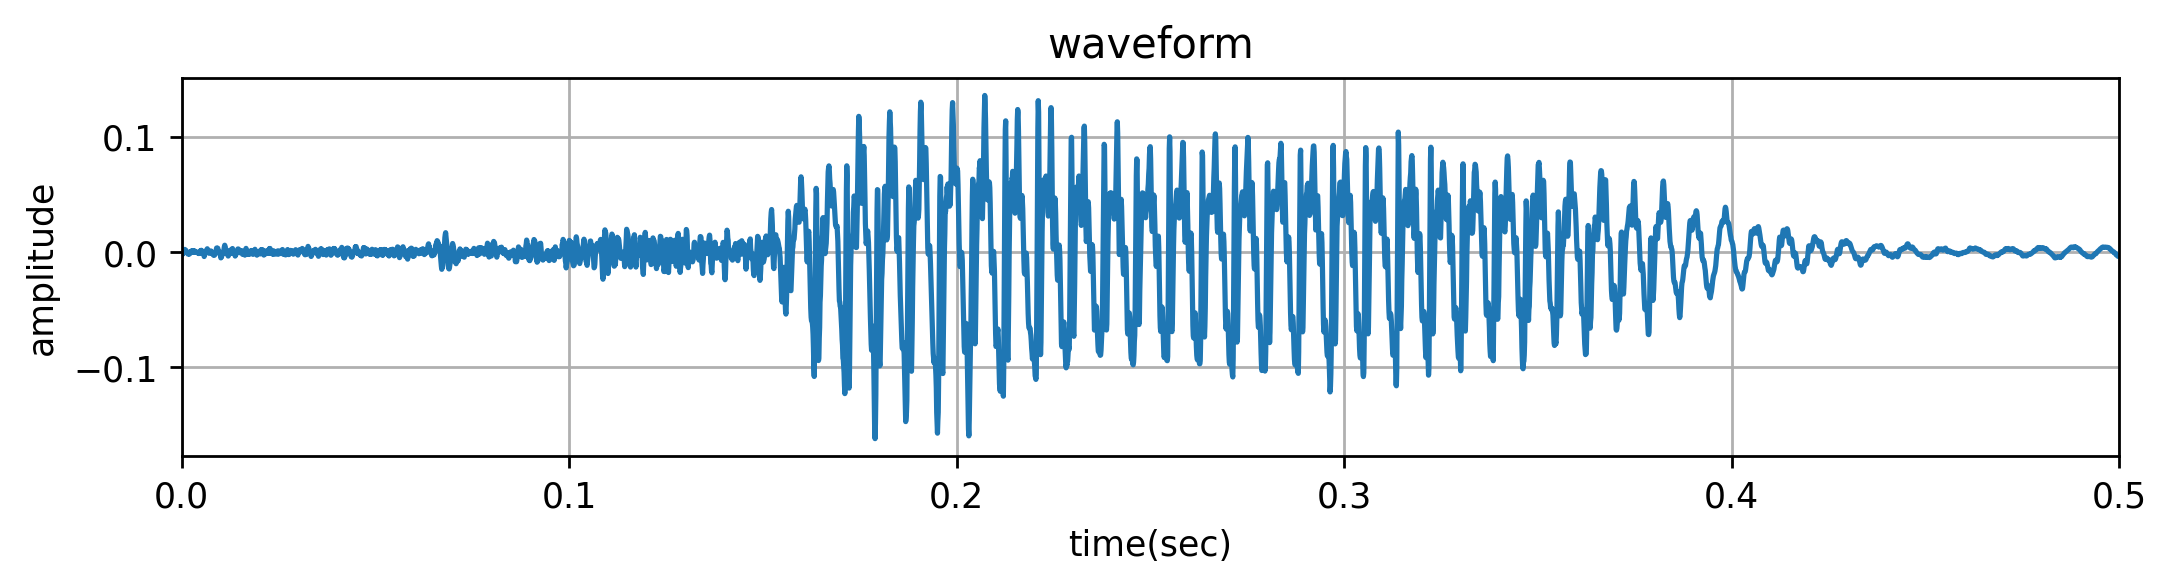

In [108]:
sig, sr = librosa.load('./Data/sa11.wav',10000)
signal = sig[9000:14000]
t_axis = np.linspace(0,0.5,5000)
plt.figure(figsize = (10,2), dpi = 250)
plt.ylabel('amplitude')
plt.title('waveform')
plt.xlabel('time(sec)')
plt.grid(True)
plt.xlim(0,0.5)
plt.plot(t_axis,signal)


## Step 1: Levinson-Durbin Algorithm: use toeplitz property

### Find coefficients a[1], .... ,a[k] which minimize the square sum of error

<img src = "./Figures/Linear_prediction.jpeg" width="70%">
<img src = "./Figures/ACR.png" width="50%">

In [ ]:
from scipy.linalg import solve_toeplitz, toeplitz

def Levinson(w_sig,p):
    r_list = [Autocor(w_sig,i) for i in range(p)]
    b_list = [Autocor(w_sig,i) for i in range(1,p+1)]
    LPC = solve_toeplitz((r_list,r_list),b_list)
    return LPC

## Step 2: Get Residual Error using LPC

#### Window type || Hamming
#### Window length || 256
#### Overlap % || 0.5

In [90]:
'''Get prediction, residual signal'''
def residual(windowed_signal, p):
    
    LPC = Levinson(windowed_signal,p)
    length = len(windowed_signal)
    prediction = np.zeros((length))
    win_sig = np.pad(windowed_signal, p)[:-p] #앞 패딩
    for k in range(length):
        prediction[k] = np.sum(win_sig[k:k+p][::-1]*LPC)
    error = windowed_signal - prediction
    return prediction, error

In [91]:
'''Get prediction, residual error for whole signal'''
def prediction(signal, window, p, overlap = 0.5):
    
    '''padding'''
    shift = int(len(window)*overlap)
    if len(signal) % shift != 0:                    
        pad = np.zeros(shift - (len(signal) % shift))  
        new_signal = np.append(signal, pad)                  
    else:
        new_signal = signal
    index = (len(new_signal) // shift) -1 
    
    '''make array'''
    whole_prediction = np.zeros((len(new_signal)),dtype = np.float128)
    whole_error = np.zeros((len(new_signal)),dtype = np.float128)
    
    for i in range(index):
        win_sig = new_signal[i*shift:i*shift+len(window)]*window #windowing
        prediction, error = residual(win_sig, p)
        whole_prediction[i*shift:i*shift+len(window)] += prediction
        whole_error[i*shift:i*shift+len(window)] += error
    
    return whole_prediction, whole_error

In [92]:
window = np.hamming(256)
pred,err = prediction(signal, window, 32)

## Visualization

In [101]:
def plot_PE(signal, whole_pred, whole_error,sr, start, end, error = False):
    
    whole_pred = whole_pred[:len(signal)]
    whole_error = whole_error[:len(signal)]
    t_axis = np.arange(len(signal))/sr
    
    plt.figure(figsize=(10,3),dpi = 250)
    plt.grid(True)
    plt.xlabel('Time(sec)')
    plt.ylabel('Amplitude')
    plt.xlim(start, end)
    
    if not error:
        plt.plot(t_axis, signal)
        plt.plot(t_axis, whole_pred, '--')
        plt.legend(['original','prediction'])
        plt.title('Original signal & Prediction')
    else:
        plt.plot(t_axis, whole_error)
        plt.title('Residual Error')
        
    plt.show()

### 본 예시의 경우 0.1\~015초 부근에서 무성음 /s/, 그리고 0.15~0.3초 부근에서 유성음 /a/ 가 나타난다. 
### 유성음/무성음 판단 근거는 Pitch_detection_SA.ipynb 파일을 참고

## Voiced (LPC order : 32)
 

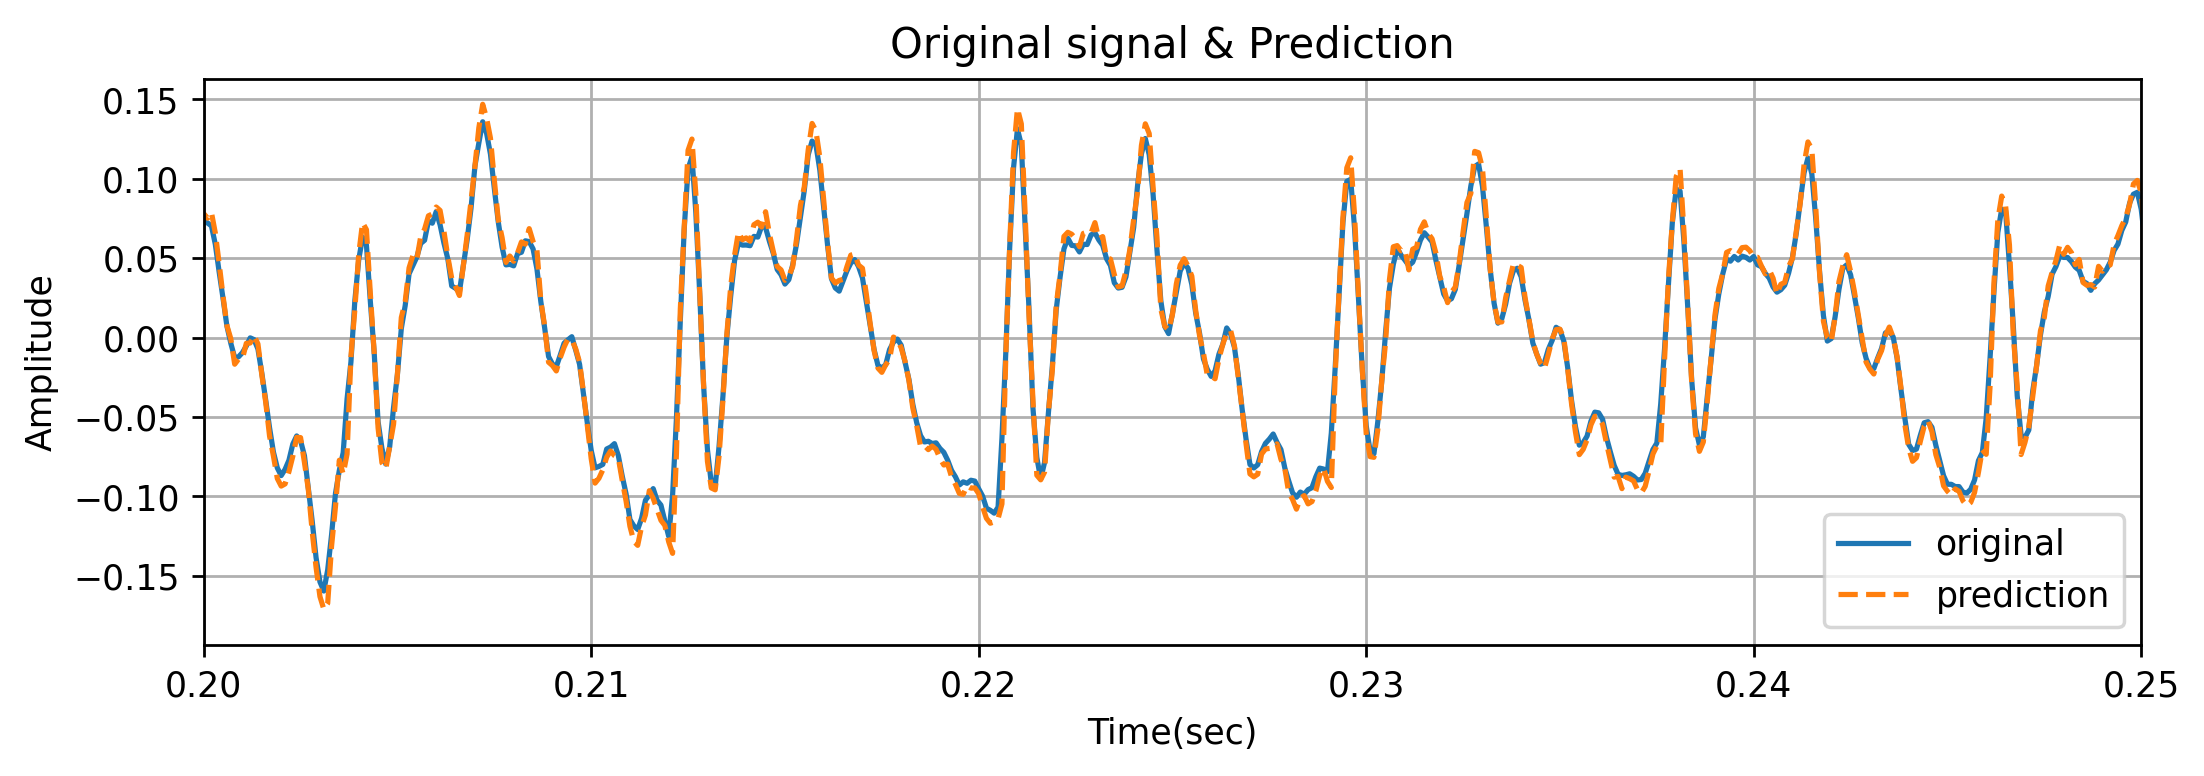

In [107]:
plot_PE(signal, pred, err, 10000, 0.2,0.25, False)

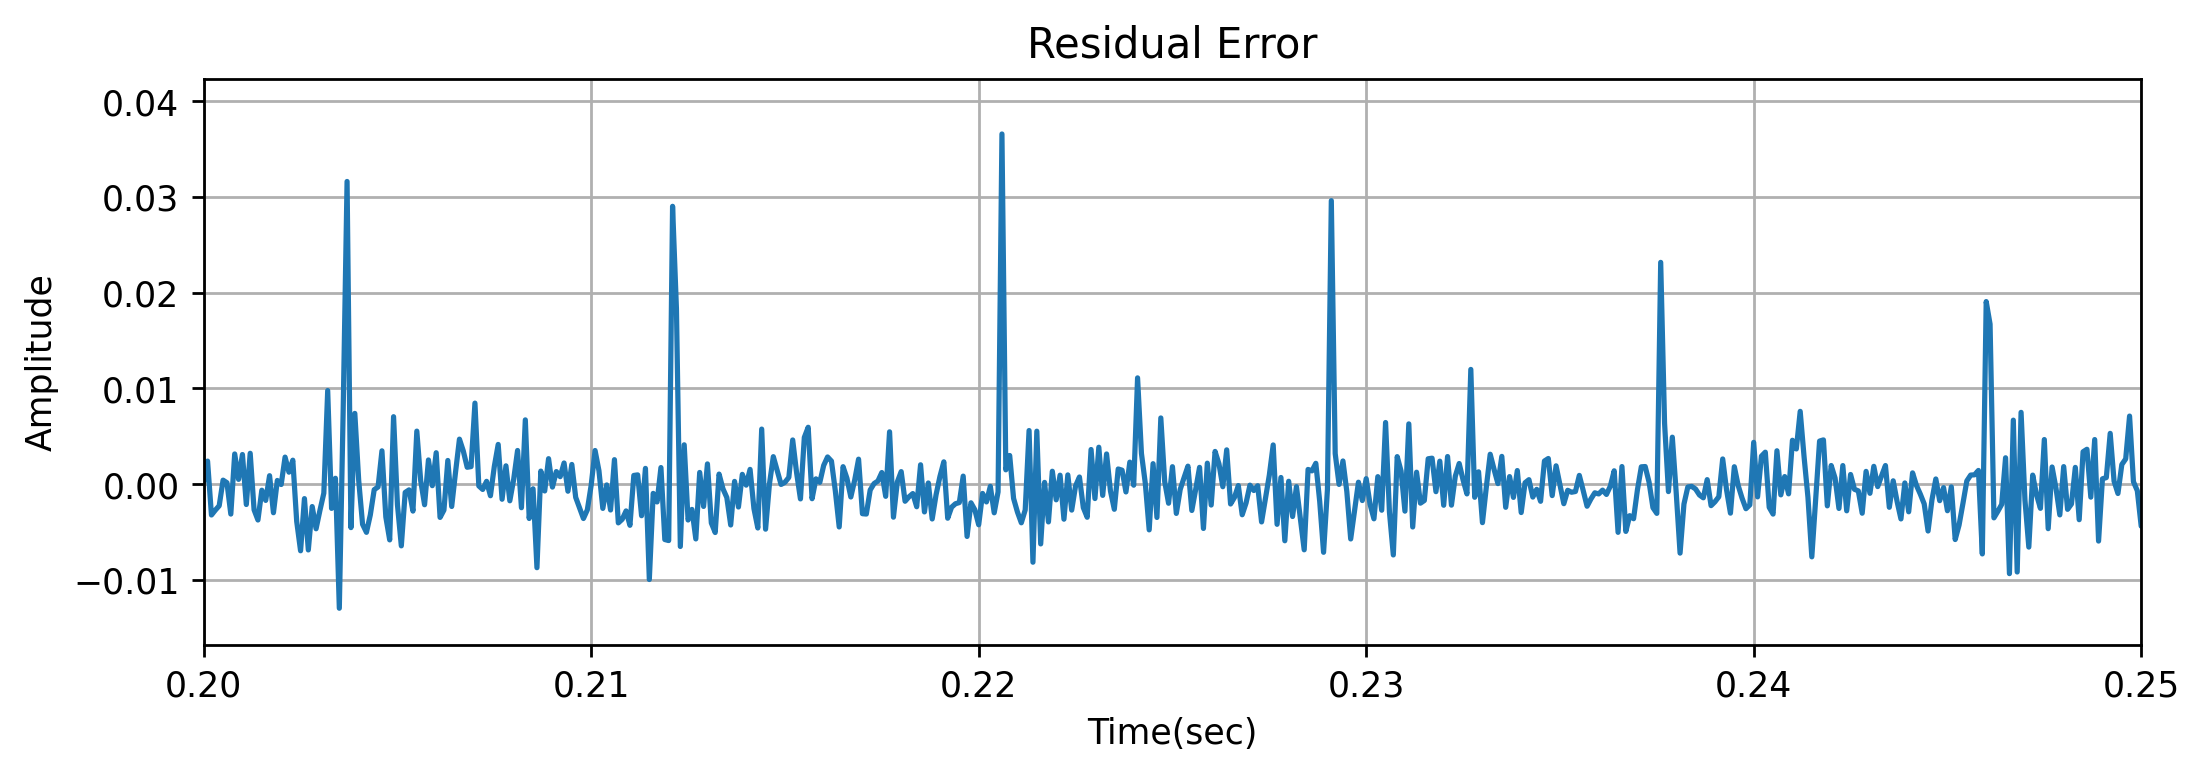

In [103]:
plot_PE(signal,pred, err, 10000, 0.2,0.25, True)

## Unvoiced (LPC order : 32)

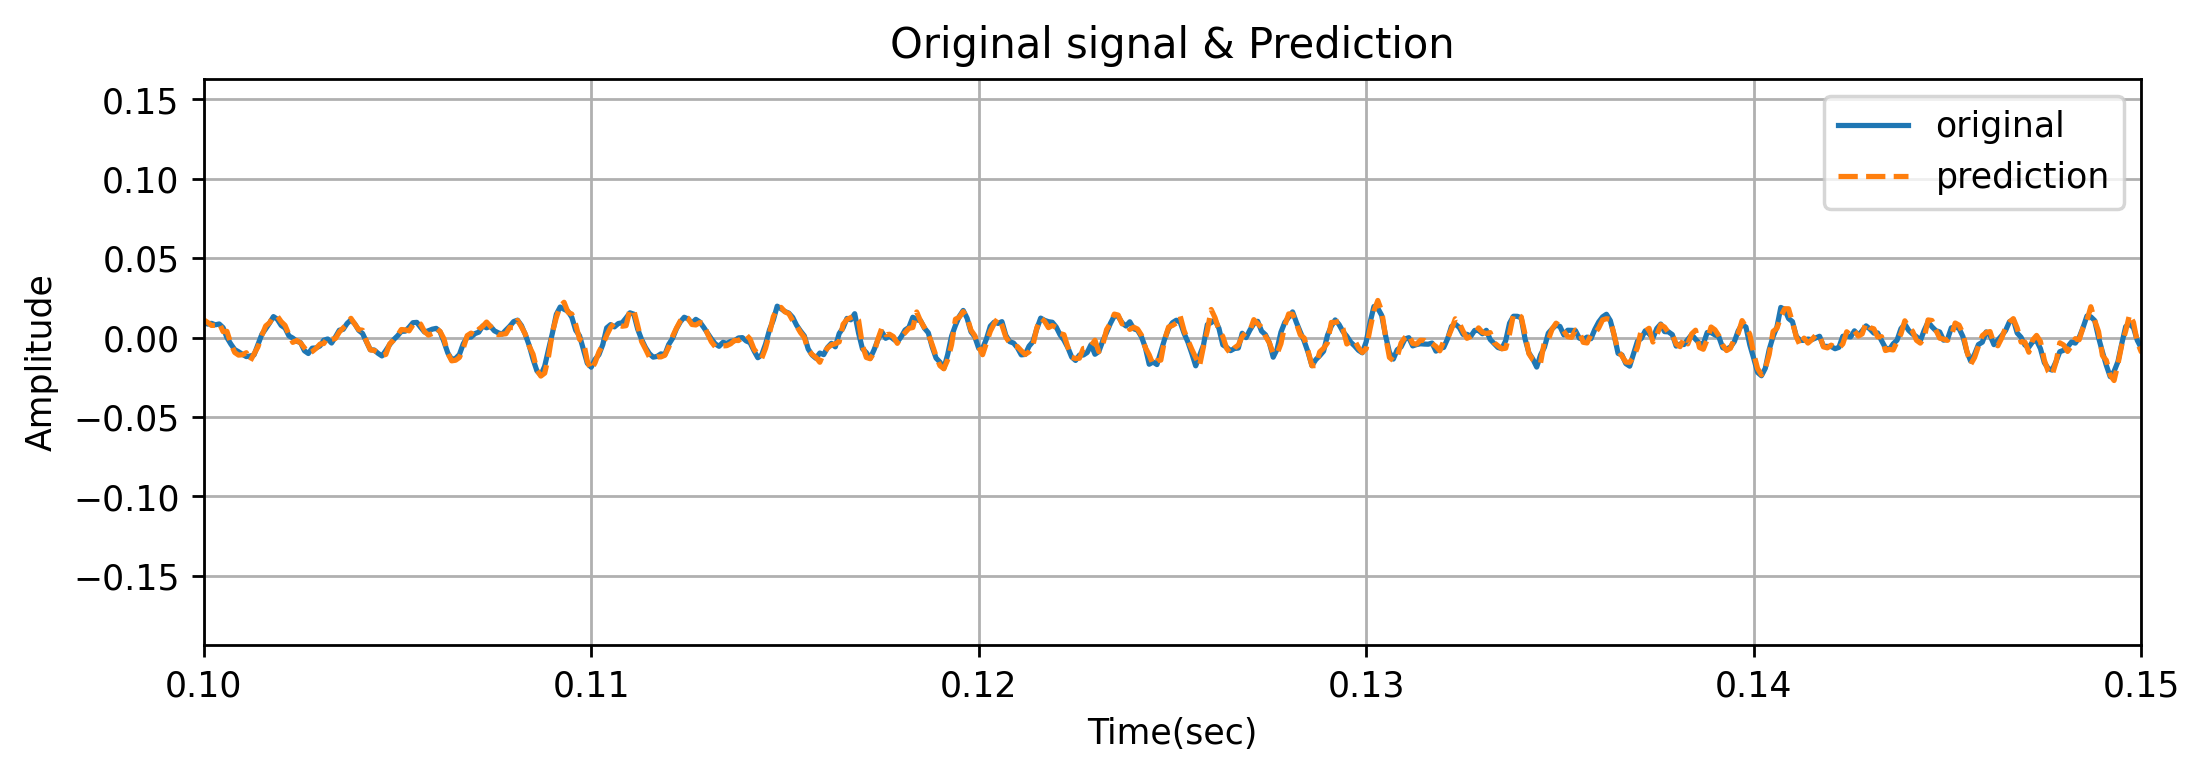

In [105]:
plot_PE(signal, pred, err, 10000, 0.1, 0.15, False)

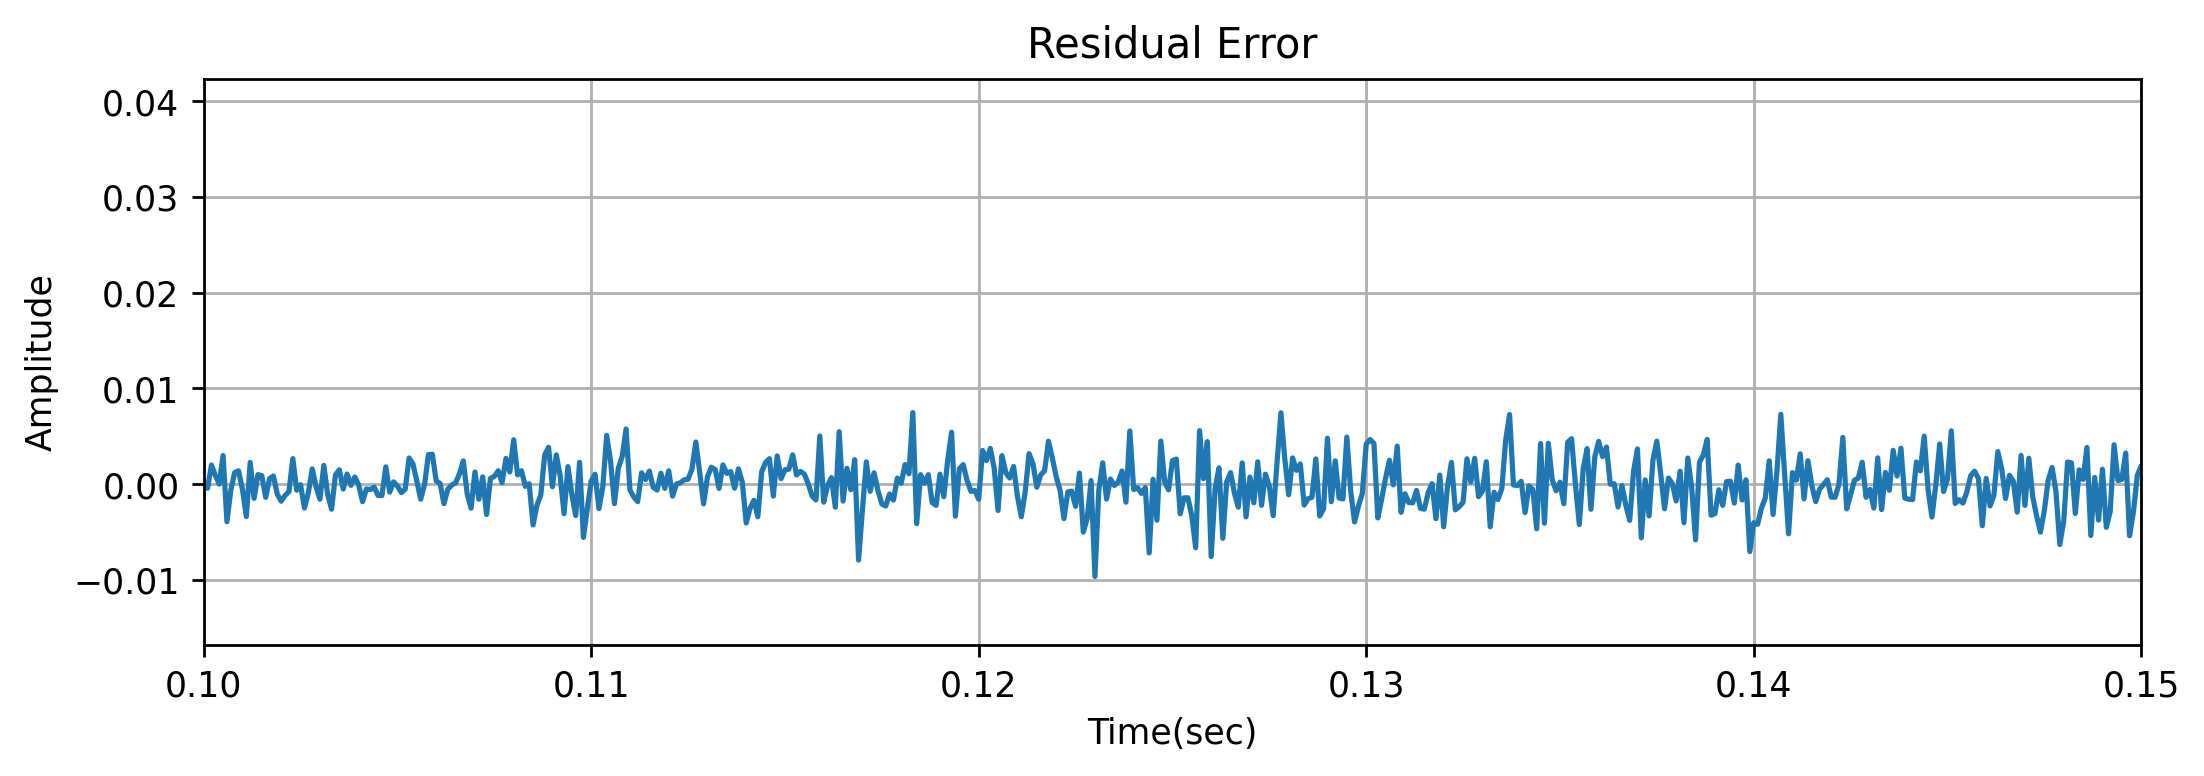

In [106]:
plot_PE(signal, pred, err, 10000, 0.1, 0.15, True)

# Step 3: Plot LPC spectrum